**Word Embeddings** are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import string
import gzip
from collections import Counter
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pprint
from pprint import pprint

import watermark
%matplotlib inline
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-11-06T20:12:26.287950-05:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 24
Architecture: 64bit



In [3]:
plt.style.use('seaborn')

# Word2vec Embeddings

**Word2Vec** is a statistical method for efficiently learning a standalone word embedding from a text corpus. 
It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding.

It learns the word embedding in one of two ways:
- either using context to predict a target word, a method known as continuous bag of words, or CBOW
- or using a word to predict a target context, which is called skip-gram, for example, we’d like to predict c context words having one target word on the input. The latter method usually produces more accurate results on large datasets.

We start by loading a well trained set of word embeddings from project polyglot: https://sites.google.com/site/rmyeid/projects./polyglot

In [4]:
word_list, embeddings = pd.read_pickle('polyglot-en.pkl')
embeddings = normalize(embeddings)
word_list = np.array(word_list)
word_dict = dict(zip(word_list, range(embeddings.shape[0])))
print(embeddings.shape)

(100004, 64)


### Find the most similar words 

In [5]:
def most_similar(word, embeddings, dictionary, reverse_dictionary, top_k=8):
    valid_word = dictionary[word]
    similarity = cosine_similarity(embeddings, embeddings[valid_word, :].reshape(1, -1))
    nearest = (-similarity).argsort(axis=0)[1: top_k + 1].flatten()
    return reverse_dictionary[nearest]

In [6]:
most_similar('King', embeddings, word_dict, word_list)

array(['Prince', 'Queen', 'Pope', 'Duke', 'Emperor', 'king', 'Wolf',
       'Dragon'], dtype='<U128')

### Analogies 

Question task set downloaded from: http://download.tensorflow.org/data/questions-words.txt

In [7]:
questions = pd.read_csv('questions-words.txt', comment=':', sep=' ', header=None)
print(questions.shape)

(19544, 4)


In [8]:
questions.head()

,0,1,2,3
0,Athens,Greece,Baghdad,Iraq
1,Athens,Greece,Bangkok,Thailand
2,Athens,Greece,Beijing,China
3,Athens,Greece,Berlin,Germany
4,Athens,Greece,Bern,Switzerland


Let us now define a function to automatically evaluate this specific type of analogy. We simply look up the embeddings for each of the four words in the question and perform the necessary vector algebra. To be safe, we enclose the entire function into a try/except block to catch the exceptions thrown when we try to use a word that is not part of our vocabulary (included in the embeddings)

In [9]:
def evaluate_analogy(question):
    word1, word2, word3, word4 = question 
    if word1 not in word_dict or \
    word2 not in word_dict or \
    word3 not in word_dict or \
    word4 not in word_dict:
        return None
    
    key1 = word_dict[word1]
    key2 = word_dict[word2]
    key3 = word_dict[word3]
    key4 = word_dict[word4]
    
    vec1 = embeddings[key1, :]
    vec2 = embeddings[key2, :]
    vec3 = embeddings[key3, :]
    vec4 = embeddings[key4, :]
    
    predict = vec2-vec1+vec3
    
    sim = np.matmul(predict, embeddings.T)
    nearest = np.argsort(-sim)[:10]
    
    return word4 in word_list[nearest]

In [10]:
evaluate_analogy(questions.iloc[1])

True

In [11]:
questions.iloc[1]

0      Athens
1      Greece
2     Bangkok
3    Thailand
Name: 1, dtype: object

In [12]:
results = [evaluate_analogy(questions.iloc[i]) for i in range(1000)]

In [13]:
clean_results = [res for res in results if res is not None]
accuracy = np.mean(clean_results)
print(accuracy)

0.528747433264887


We this simple approach we achieve ~53% accuracy. Our results are penalized by the fact that our embeddings weren't generated specifically for this purpose and are missing some of the words used in the analogies.

### Visualizing the embeddings space

Another exciting operation we can do with embeddings is visualization. Plotting the embeddings in a 2D dimensional space can show us how words are related. Most similar words should be plotted in groups while non related words will appear in a large distance. This requires a further dimension reduction technique to get the dimensions to 2 or 3. The most popular technique for reduction is itself an embedding method: **t-Distributed Stochastic Neighbor Embedding (TSNE)**.

**t-SNE** is a technique for dimensionality reduction that is best suited for the visualization of high dimensional datasets.

**t-SNE** is a manifold learning technique which means that it tries to map high-dimensional data to a lower-dimensional manifold, creating an embedding that attempts to maintain local structure within the data. It's almost exclusively used for visualization because the output is stochastic and it does not support transforming new data.

In [15]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(np.array(embeddings)[:plot_only, :])
labels = [word_list[i] for i in range(plot_only)]

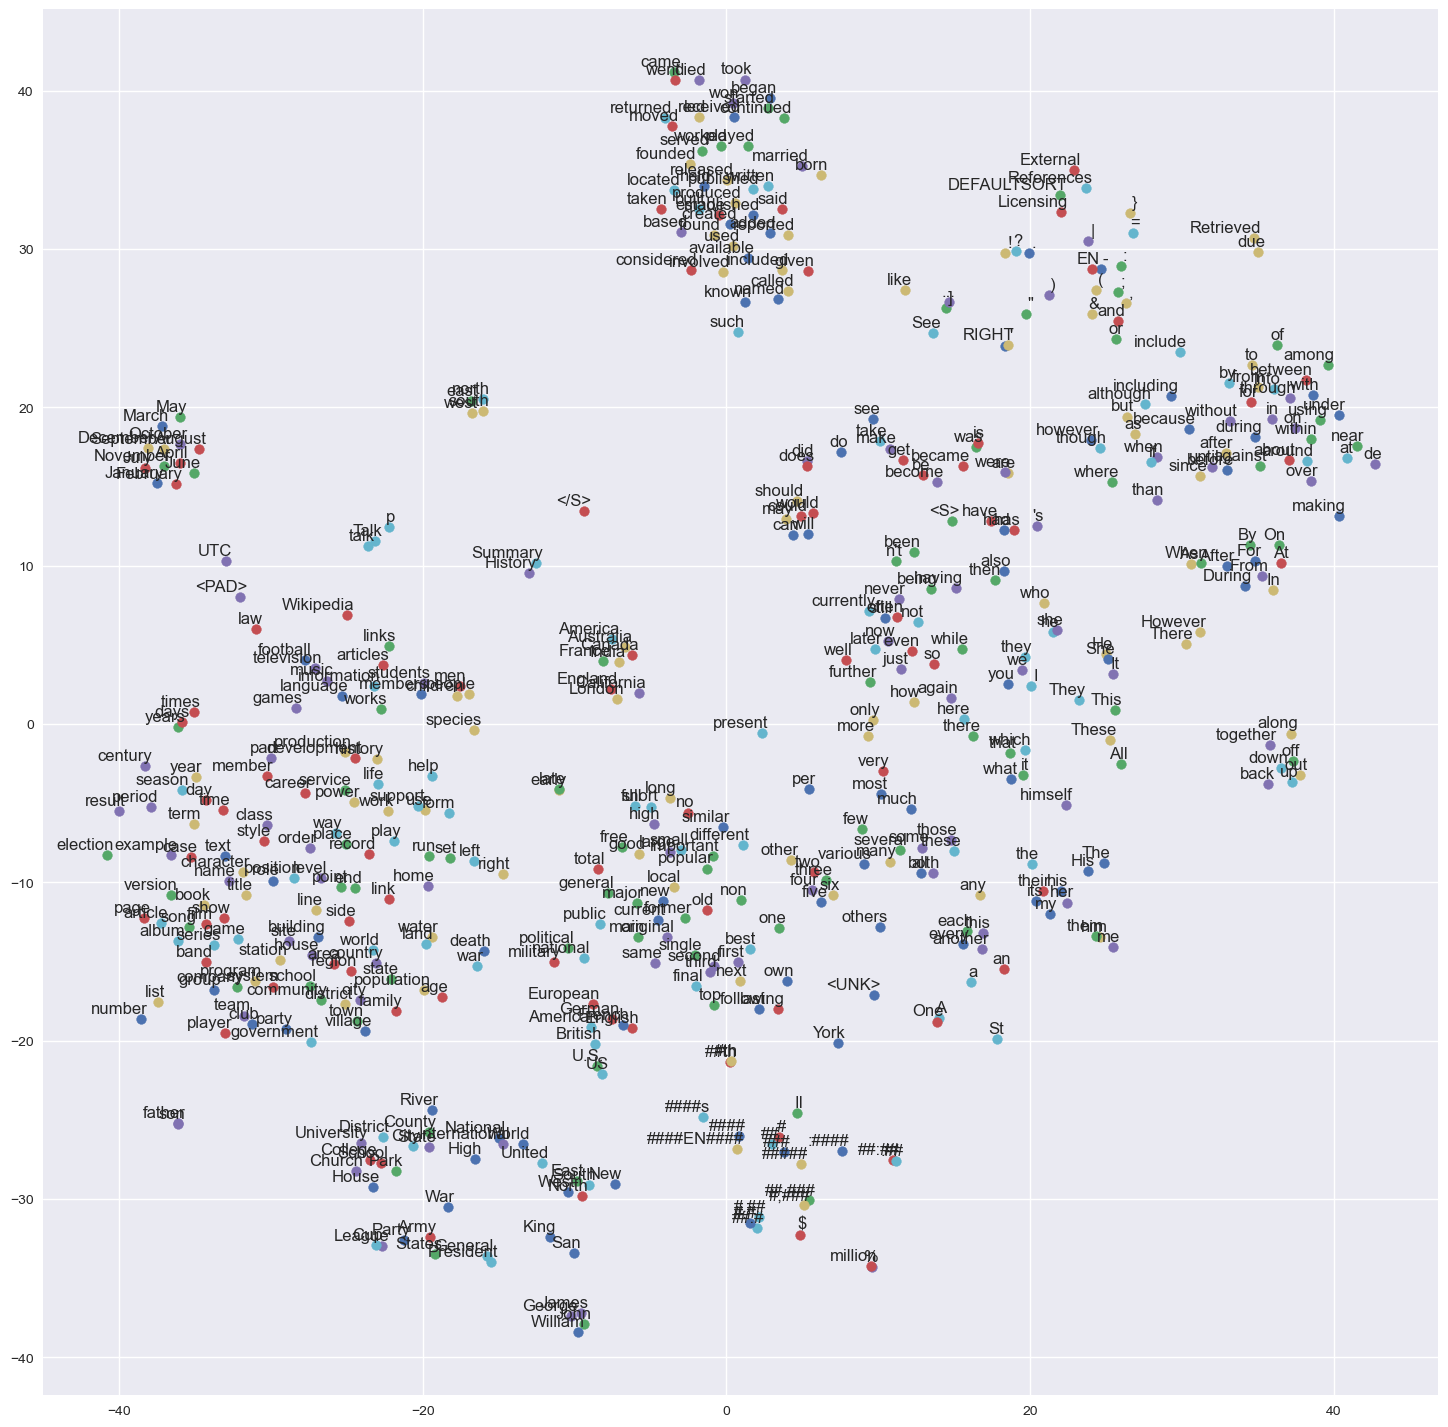

In [16]:
plt.figure(figsize=(18, 18))

for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                xy=(x, y),
                xytext=(5, 2),
                 textcoords='offset points',
                ha='right',
                va='bottom',
                fontsize=12)

# Global Vectors for Word Representation (GloVe)

The **Global Vectors for Word Representation**, or **GloVe**, algorithm is an extension to the word2vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford. 

**GloVe** is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Files with the pre-trained vectors **Glove** can be found in many sites like Kaggle or in the previous link of the Stanford University. We will use the glove.6B.100d.txt file containing the glove vectors trained on the Wikipedia and GigaWord dataset.

First we convert the **GloVe** file containing the word embeddings to the word2vec format for convenience of use. We can do it using the gensim library, a function called glove2word2vec.

We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format that will be loaded in the next section

In [19]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_filename = 'glove.6B.100d.txt'
glove_path = 'data/' + glove_filename
word2vec_output_file = glove_filename + '.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

(400000, 100)

So our vocabulary contains 400K words represented by a feature vector of shape 100. 

In [20]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to king - man + woman: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

### Analyzing the vector space and find analogies

We would like extract some interesting features of our word embeddings. Our words are numerical vectors so we can measure and compare distances between words to show some of the properties that these embedding provide.

For example, we can compare some analogies. The most famous is the following: king – man + woman = queen. In other words, adding the vectors associated with the words king and woman while subtracting man is equal to the vector associated with queen. In others words, subtracting the concept of man to the concept of King we get a representation of the "royalty". Then, if we sum to the woman word this concept we obtain the word "queen". Another example is: france – paris + rome = italy. In this case, the vector difference between paris and france captures the concept of country.

Now we will show some of thise analogies in different topics.

In [21]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('King - Man + Woman = ',result)
result = model.most_similar(positive=['rome', 'france'], negative=['paris'], topn=1)
print('France - Paris + Rome = ',result)
result = model.most_similar(positive=['english', 'france'], negative=['french'], topn=1)
print('France - french + english = ',result)
result = model.most_similar(positive=['june', 'december'], negative=['november'], topn=1)
print('December - November + June = ',result)
result = model.most_similar(positive=['sister', 'man'], negative=['woman'], topn=1)
print('Man - Woman + Sister = ',result)

King - Man + Woman =  [('queen', 0.7698541283607483)]
France - Paris + Rome =  [('italy', 0.8295993208885193)]
France - french + english =  [('england', 0.7678162455558777)]
December - November + June =  [('july', 0.9814670085906982)]
Man - Woman + Sister =  [('brother', 0.8288711309432983)]


We can extract which words are more similar to another word, so they all are "very close" in the vector space.

In [23]:
def display_most_similar(results):
    print("\n".join(f"Word: {res[0]} - Similarity: {res[1]}" for res in results))

In [24]:
result = model.most_similar(positive=['spain'], topn=10)
print('10 most similar words to Spain: ')
display_most_similar(result)

result = model.most_similar(positive=['football'], topn=10)
print('\n10 most similar words to Football: ')
display_most_similar(result)

result = model.most_similar(positive=['doctor'], topn=10)
print('\n10 most similar words to Doctor: ')
display_most_similar(result)

10 most similar words to Spain: 
Word: portugal - Similarity: 0.7970702648162842
Word: argentina - Similarity: 0.7758234143257141
Word: italy - Similarity: 0.7746187448501587
Word: france - Similarity: 0.7557463049888611
Word: spanish - Similarity: 0.7347224354743958
Word: brazil - Similarity: 0.7244943976402283
Word: mexico - Similarity: 0.7206876277923584
Word: madrid - Similarity: 0.7078269124031067
Word: morocco - Similarity: 0.7001035213470459
Word: netherlands - Similarity: 0.6802704334259033

10 most similar words to Football: 
Word: soccer - Similarity: 0.8732221722602844
Word: basketball - Similarity: 0.8555637001991272
Word: league - Similarity: 0.8153361678123474
Word: rugby - Similarity: 0.8007533550262451
Word: hockey - Similarity: 0.7833694815635681
Word: club - Similarity: 0.7730998992919922
Word: team - Similarity: 0.7720499038696289
Word: baseball - Similarity: 0.76057368516922
Word: players - Similarity: 0.7399718761444092
Word: player - Similarity: 0.7376237511634827

Lets show some measure of similarities between words

In [25]:
result = model.similar_by_word("cat")
print(" Cat is similar to {}: {:.4f}".format(*result[0]))
result = model.similar_by_word("father")
print(" Father is similar to {}: {:.4f}".format(*result[0]))

 Cat is similar to dog: 0.8798
 Father is similar to son: 0.9240


### Visualization of word embeddings

In [26]:
from sklearn.manifold import TSNE
    
def tsne_plot(model, words):
    "Creates TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

For example, we will plot a hundred words from our word embeddings and also the most similar words to the concept of woman and car. All similar words should be plotted closely, while the rest of words will apear distributed across the vector space:

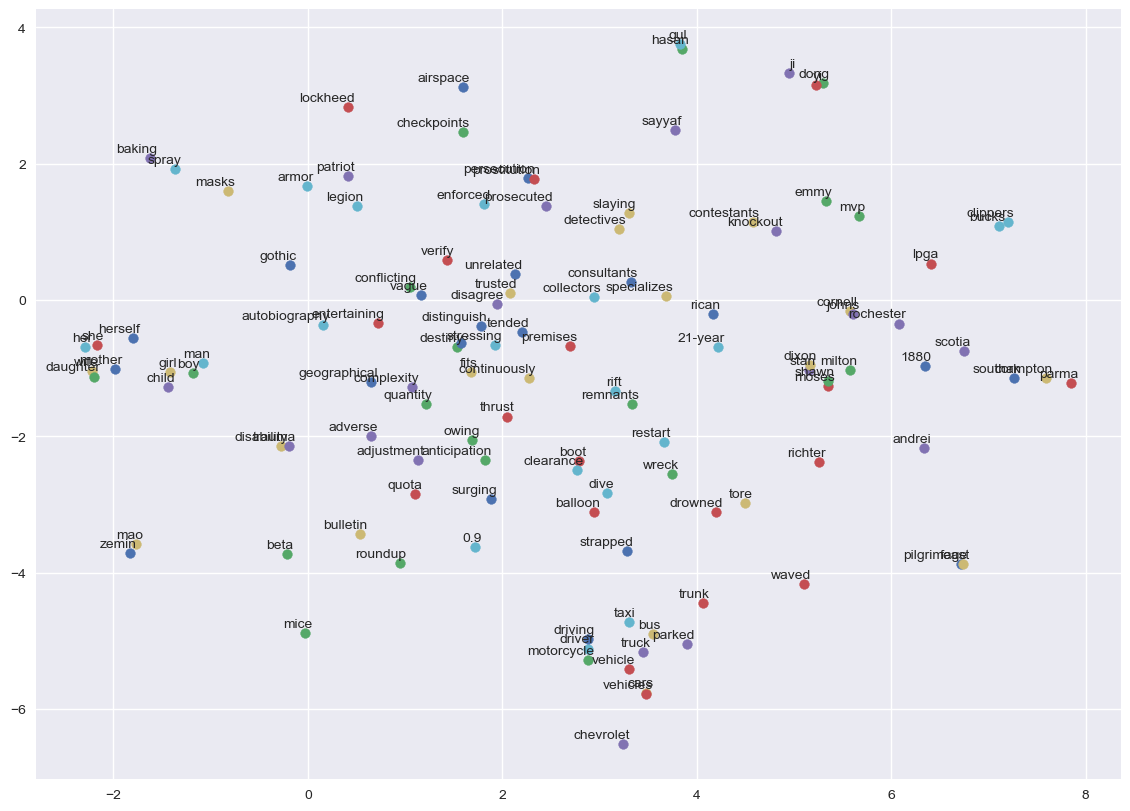

In [27]:
words = list(model.index_to_key)

word1 = words[10000:10100]
words2= model.similar_by_word('woman')
words3= model.similar_by_word('car')
words= word1 + [w[0] for w in words2] + [w[0] for w in words3]

tsne_plot(model, words)